# Part 6: Regression (Machine Learning)
by Leslie Kerby

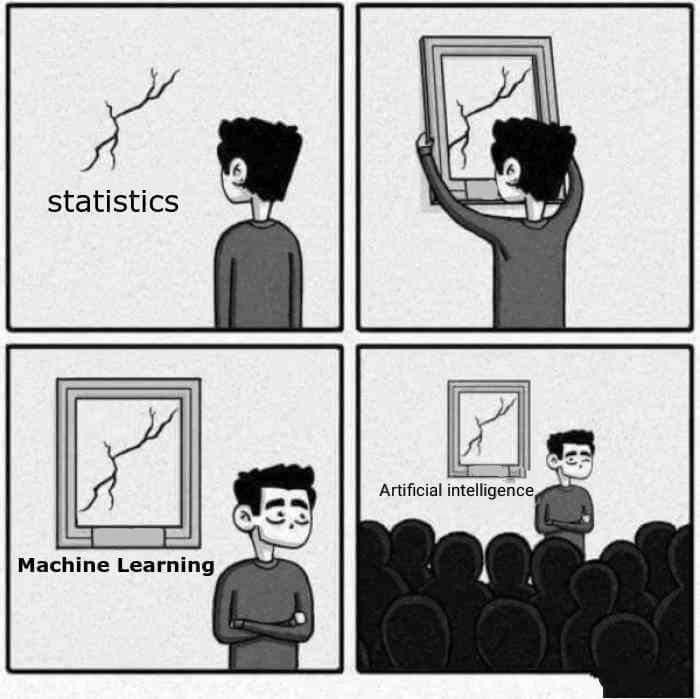
https://towardsdatascience.com/no-machine-learning-is-not-just-glorified-statistics-26d3952234e3

>“*When you’re fundraising, it’s AI. When you’re hiring, it’s ML. When you’re implementing, it’s logistic regression.*”
<br/>—everyone on Twitter ever

Regression as used in Machine Learning varies in two ways from its use in 'pure statistics':
- It is massively multiple (not just a couple factors, but sometimes dozens or hundreds) 
- Datasets are split into train and test sets (tells us if we've overfit)

Let's look at our Galton heights dataset again and this time we won't just look at one factor, `midparentHeight`, to predict `childHeight`, but we will use all the data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#heights = pd.read_csv('https://gitlab.com/CEADS/DrKerby/python/raw/master/galton.csv')
heights = pd.read_csv('galton.csv')
heights.head()

The Pandas method `scatter_matrix` is useful to look for regression between all of the factors. It plots a mini scatter plot for each combination of factors.

In [ ]:
pd.scatter_matrix(heights, figsize=(10,10))
plt.show()

But we have eight factors in our `heights` DataFrame. Why are only six of them showing up? `gender` isn't showing up because it is not numerical. But `family` isn't either, even though it appears to be a number. Let's check it out with the `loc` or `iloc` method. `iloc` uses integers in the index of the DataFrame, [row, column], to access elements and slices, just like you normally would a 2D array. `loc` uses the column labels, not numbers.

In [ ]:
heights.loc[0,'family']

In [ ]:
type(heights.iloc[0,0])

**Lambda Functions**<br/>
Python has a temporary function called `lambda` functions, which don't have a name or a formal definition like traditional functions. Lambda functions are particularly useful when passing functions to methods like `apply`. The format for lambda functions is:

In [ ]:
lambda paramter_arguments : return_expression

As an example, an equivalent lambda function to our `str_to_num` function is <br/>
```
lambda string : float(string.strip('$').replace(',',''))
```
Let's use a lambda in our `apply` method.

Note that it does not matter what you call `string`, Python assumes it stands in as the dummy variable for each element in the DataFrame column you are `apply`ing on. We could use `x` instead.

**Question 3.1**<br/>
Using the `apply` method with a lambda function, convert the `family` column elements to integers.

In [ ]:
# Will give error
...

You get an error. Why? It says it can't convert '136A' to an integer. We didn't know that `family` had non-numbers in it...

**Question 3.2**<br/>
Print out the elements of `heights` where `family` equals '136A'.

In [ ]:
...

Let's use `nunique` and `unique` to investigate if there are any other non-numbers in `family`. `nunique` gives you the number of unique elements while `unique` gives you an array of those unique elements.

In [ ]:
heights['family'].nunique()

In [ ]:
heights.tail()

In [ ]:
heights['family'].unique()

Ok, there are no other non-numbers in `family`.

**Question 3.3**<br/>
Re-label family '136A' as family '205'. Use a normal function with `apply`. <br/>
Then convert `family` to integers using another lambda function with `apply`.

In [ ]:
...

In [ ]:
heights['family'].unique()

In [ ]:
heights[ heights['family'] == '136A' ]

In [ ]:
heights['family'] = heights['family'].apply(lambda x : int(x))
heights.head()

In [ ]:
heights.iloc[0,0]

Now `family` should show up on our scatter matrix.

In [ ]:
pd.scatter_matrix(heights, figsize=(10,10))
plt.show()

Now to 'numerical-ize' the `gender` column as well. We could use 0 for female and 1 for male. However, the practice of converting categories to ordered numbers is discouraged because it introduces biases in your machine learning (if the algorithm assumes ordered numbers may mean something, which most do). It is better to use a Pandas method called `get_dummies` which will create non-biasing factors for us. 

In [ ]:
df = pd.get_dummies(heights, columns=['gender'])
df.head()

Now we can plot our `scatter_matrix` again.

In [ ]:
pd.scatter_matrix(df, figsize=(15,15))
plt.show()

In general it would have been preferable to use `get_dummies` on our `family` column as well, as the numbers were more categorical rather than indicating numerical order. However, this would have given us over 200 factors, which for a dataset with less than 1000 samples, in my opinion is not practical. We will also see shortly that we will eliminate the `family` column altogether. But first, let's machine learn the whole dataset.

We are ready to to separate the factors from our predicted variable `childHeight`, and split our dataset into train and test sets. We use `train_test_split` from `sklearn.model_selection`.

In [ ]:
factorsdf = df.drop('childHeight', axis=1)
factorsdf
answers = df['childHeight']
answers

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(factorsdf,answers, test_size=1/5.0)

In [ ]:
Xtrain.head() # inspect the train and test sets

In [ ]:
ytrain.head()

In [ ]:
Xtest.head()

In [ ]:
ytest.head()

Now we load the `LinearRegression` model from `sklearn.linear_model` and train it on our training dataset.

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(Xtrain, ytrain)

Use our new `reg` model to make predictions.

In [ ]:
predictions = reg.predict(Xtest)

**Question 3.4.**<br/>
Using these predictions, calculate the RMSE. `import math` to use the `math.sqrt` function.

In [ ]:
import math
...

To find the equation from our linear regression, we utilize the `coef_` and `intercept_` methods of the regression fit object `reg`.

In [ ]:
reg.coef_

In [ ]:
factorsdf.head()

In [ ]:
reg.intercept_

To print this out in a nice format, we can use the `format` string method, and note that we can access column names through the DataFrame method `columns`.

In [ ]:
factorsdf.columns

In [ ]:
# Just run this cell.

equation = 'childHeight = '

for i in np.arange(reg.coef_.size):
    equation += '({:.4f})*{} + '.format(reg.coef_[i],factorsdf.columns[i])

equation += '({:.4f})'.format(reg.intercept_)
equation

Compare this to the equation we had previously:

> childHeight = 0.64\*midparentHeight + 22.64

**Double check our assumptions**<br/>
Now we are not done. We need to double check our analysis to make sure it is reasonable. In particular, we need to understand what our data is representing. We have assumed that the `family` column was randomly collected (in other words, there was no particular order to our data collection, and no particular order to the numbers in `family`. Let's look at this more closely. We can look back up at our scatter_matrix, but for simplicity the scatter plot of `family` vs `father` height is shown below.

In [ ]:
df.plot.scatter('family','father')

The `family`s are actually ordered by the father's height! This is why that `family` `136A` was included, presumably later, and inserted into the middle of the dataset instead of being added to the end at 205 (where it sticks out now).

This is not physical. This is an order that the human data collector has added (biased) to the dataset, and so we cannot use it in our analytics. Think about it, if we later have a mother/father height and we want to predict the child's height, we cannot possibly know where in the `family` order it should belong. So this `family` column needs to be removed.

In [ ]:
modfactorsdf = factorsdf.drop('family', axis=1)
modfactorsdf.head()

We have also assumed that the `childNum` column is a reference to the age of the children: first, second, etc. Let's double check this assumption by looking at the scatterplot of `childNum` vs `childHeight`.

In [ ]:
df.plot.scatter('childNum','childHeight')

Again, we see that our assumption was not correct. `childNum` has been sorted in the dataset, not by age, but by *height*. In other words, the tallest child is `1`, the second-tallest is `2`. Again, this is not physical and is introduced bias by the human data collector. We want our model to work regardless of whether or not we know how the child's height compares to their siblings. So we remove the `childNum` column.

In [ ]:
modfactorsdf = modfactorsdf.drop('childNum', axis=1)
modfactorsdf.head()

Now let's run the regression model again.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
Xtrain, Xtest, ytrain, ytest = train_test_split(modfactorsdf,answers,test_size=1/5)
regmod = LinearRegression().fit(Xtrain,ytrain)

Let's find the RMSE error for this *corrected* regression model.

In [ ]:
import math
predictions = regmod.predict(Xtest)
residuals = predictions - ytest
squares = residuals**2
sums = sum(squares)
rmse = math.sqrt(sums/len(ytest))
rmse

It is not quite as good as we had previously (though with random sampling it is possible to get a result as good), but it is still much better than the simple univariate statistical regression we did previously (that had RMSE about 3.4). <br/>
There is also an easy way to calculate the mean-squared error using the `mean_squared_error` method in `sklearn.metrics`. Simply take the square root of it to get RMSE.

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(ytest,predictions)
rmse = math.sqrt(mse)
rmse

And now let's print out our equation for this regression model.

In [ ]:
# Just run this cell.

equation = 'childHeight = '

for i in np.arange(regmod.coef_.size):
    equation += '({:.4f})*{} + '.format(regmod.coef_[i],modfactorsdf.columns[i])

equation += '({:.4f})'.format(regmod.intercept_)
equation

An important aspect of data science is interpretability. How do you explain your model? Is it sensible? 

Take a look at our regression equation. It is not sensible. There are *huge* coefficients in front of the factors `father`, `mother`, and `midparentHeight`. If you look closely, you'll notice that both father and mother are negative, and midparentHeight is about twice as positive--meaning that the three factors add up to some small correlation. We can remove this aberration by dropping the `midparentHeight` column from our dataset. It is an engineered feature anyway, and not part of the core data.

In [ ]:
mod2df = modfactorsdf.drop('midparentHeight', axis='columns')
mod2df.head()

In [ ]:
from sklearn.metrics import mean_squared_error
Xtrain, Xtest, ytrain, ytest = train_test_split(mod2df, answers, test_size=1/5)
regmod2 = LinearRegression().fit(Xtrain,ytrain)
predictions = regmod2.predict(Xtest)
print(math.sqrt(mean_squared_error(ytest,predictions))) # will be RMSE

equation = 'childHeight = '
for i in np.arange(regmod2.coef_.size):
    equation += '({:.4f})*{} + '.format(regmod2.coef_[i],mod2df.columns[i])

equation += '({:.4f})'.format(regmod2.intercept_)
equation

This regression equation is sensible. And we still have a much-improved RMSE compared to only using the factor `midparentHeight`.

**Coefficient of determination, $R^2$**<br/>
The proportion of the variance in the dependent variable that is predictable from the independent variable(s).

<p style="text-align: center;">
$R^2 = 1 - \frac{MSE}{\sigma^2} $
</p>

The method `score` will calculate $R^2$ for us.

In [ ]:
regmod2.score(Xtest, ytest)

In [ ]:
regmod2.score(Xtrain, ytrain)